In [1]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import json 

from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from utils_preprocessing import eis_dataframe_from_csv
from utils_preprocessing import process_batch_element_f
from utils_preprocessing import process_batch_element_zreal
from utils_preprocessing import process_batch_element_zimag
from utils_preprocessing import exclude_outlier

from utils import plot_freq_range
from utils import umap_plots

/home/joachimschaeffer/anaconda3/envs/eis-ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-14 13:13:02.623912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 13:13:02.888535: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joachimschaeffer/anaconda3/envs/eis-ml/lib/python3.9/site-packages/cv2/../../lib64:
2023-03-14 13:13:02.888592: I

In [2]:
# Load the csv into a data frame.
df = eis_dataframe_from_csv("data/train_data.csv")
df_test = eis_dataframe_from_csv("data/test_data.csv")
save_figs = 0

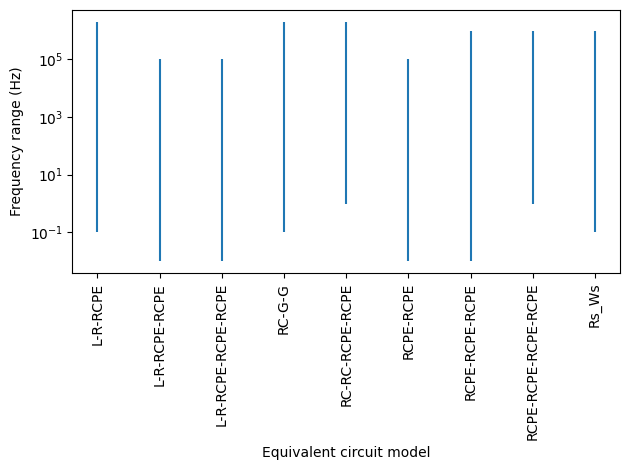

['L-R-RCPE' 'L-R-RCPE-RCPE' 'L-R-RCPE-RCPE-RCPE' 'RC-G-G'
 'RC-RC-RCPE-RCPE' 'RCPE-RCPE' 'RCPE-RCPE-RCPE' 'RCPE-RCPE-RCPE-RCPE'
 'Rs_Ws'] [ 9  4 15 23  3  0  5  8 13]
Maximal minimum freq: 10.0, minimal maximum freq: 100000.0


In [3]:
plot_freq_range(df, save=save_figs)

In [4]:
def interpolate_to_freq_range(df):
    ## Interpolate onto the largest frequency union to prevent data leakage
    interpolated_basis = np.geomspace(10, 1e5, num=30)

    df["f"] = df.apply(lambda x: process_batch_element_f(interpolated_basis), axis=1)
    df["zreal"] = df.apply(
        lambda x: process_batch_element_zreal(x.freq, x.Z, interpolated_basis), axis=1
    )
    df["zimag"] = df.apply(
        lambda x: process_batch_element_zimag(x.freq, x.Z, interpolated_basis), axis=1
    )

    # Sort the data frame to get the circuit names in alphabetical order
    df_sorted = df.sort_values(by=["Circuit"])
    return df_sorted

In [5]:
df_sorted = interpolate_to_freq_range(df)
df_test_sorted = interpolate_to_freq_range(df_test)

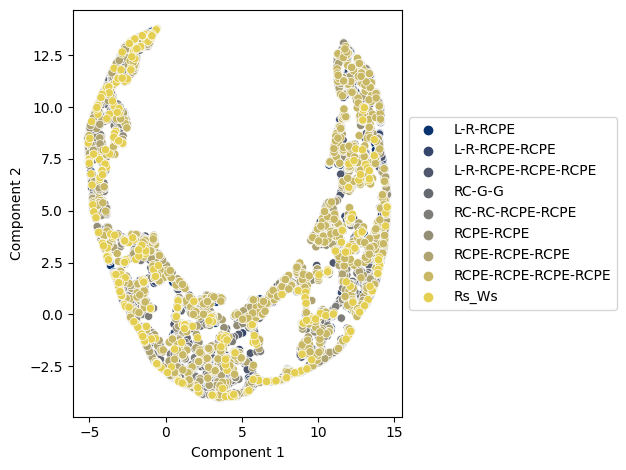

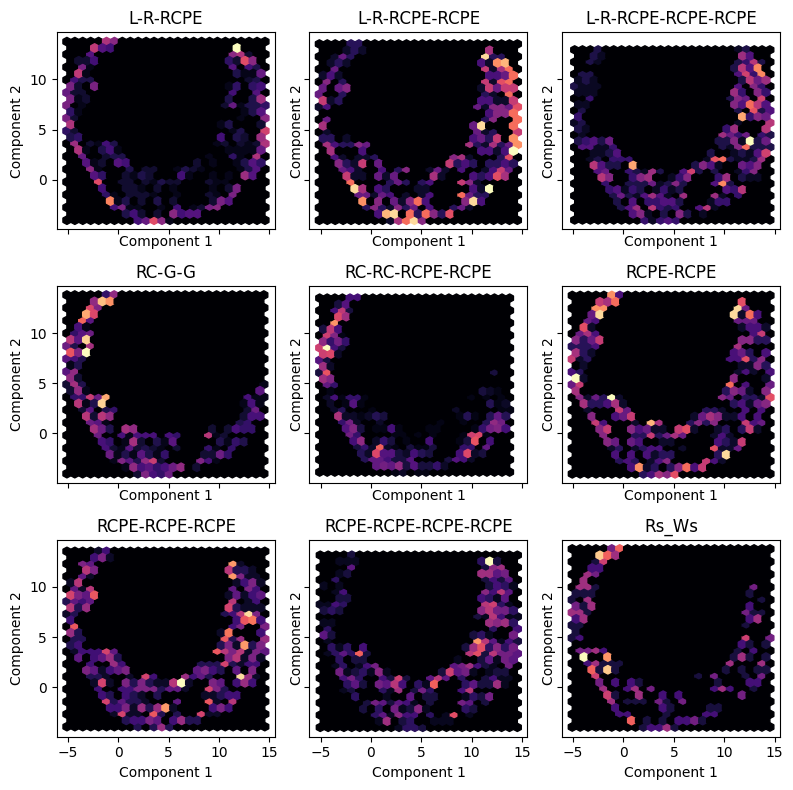

In [6]:
# Umap random state fixed (plots differ slightly from publication, because the seed was previously not fixed).
# Even though the seed is fixed, subple changes can occur (probabaly due to the stochastic nature of UMAP.)
umap_plots(df_sorted, save=save_figs, random_state=42)

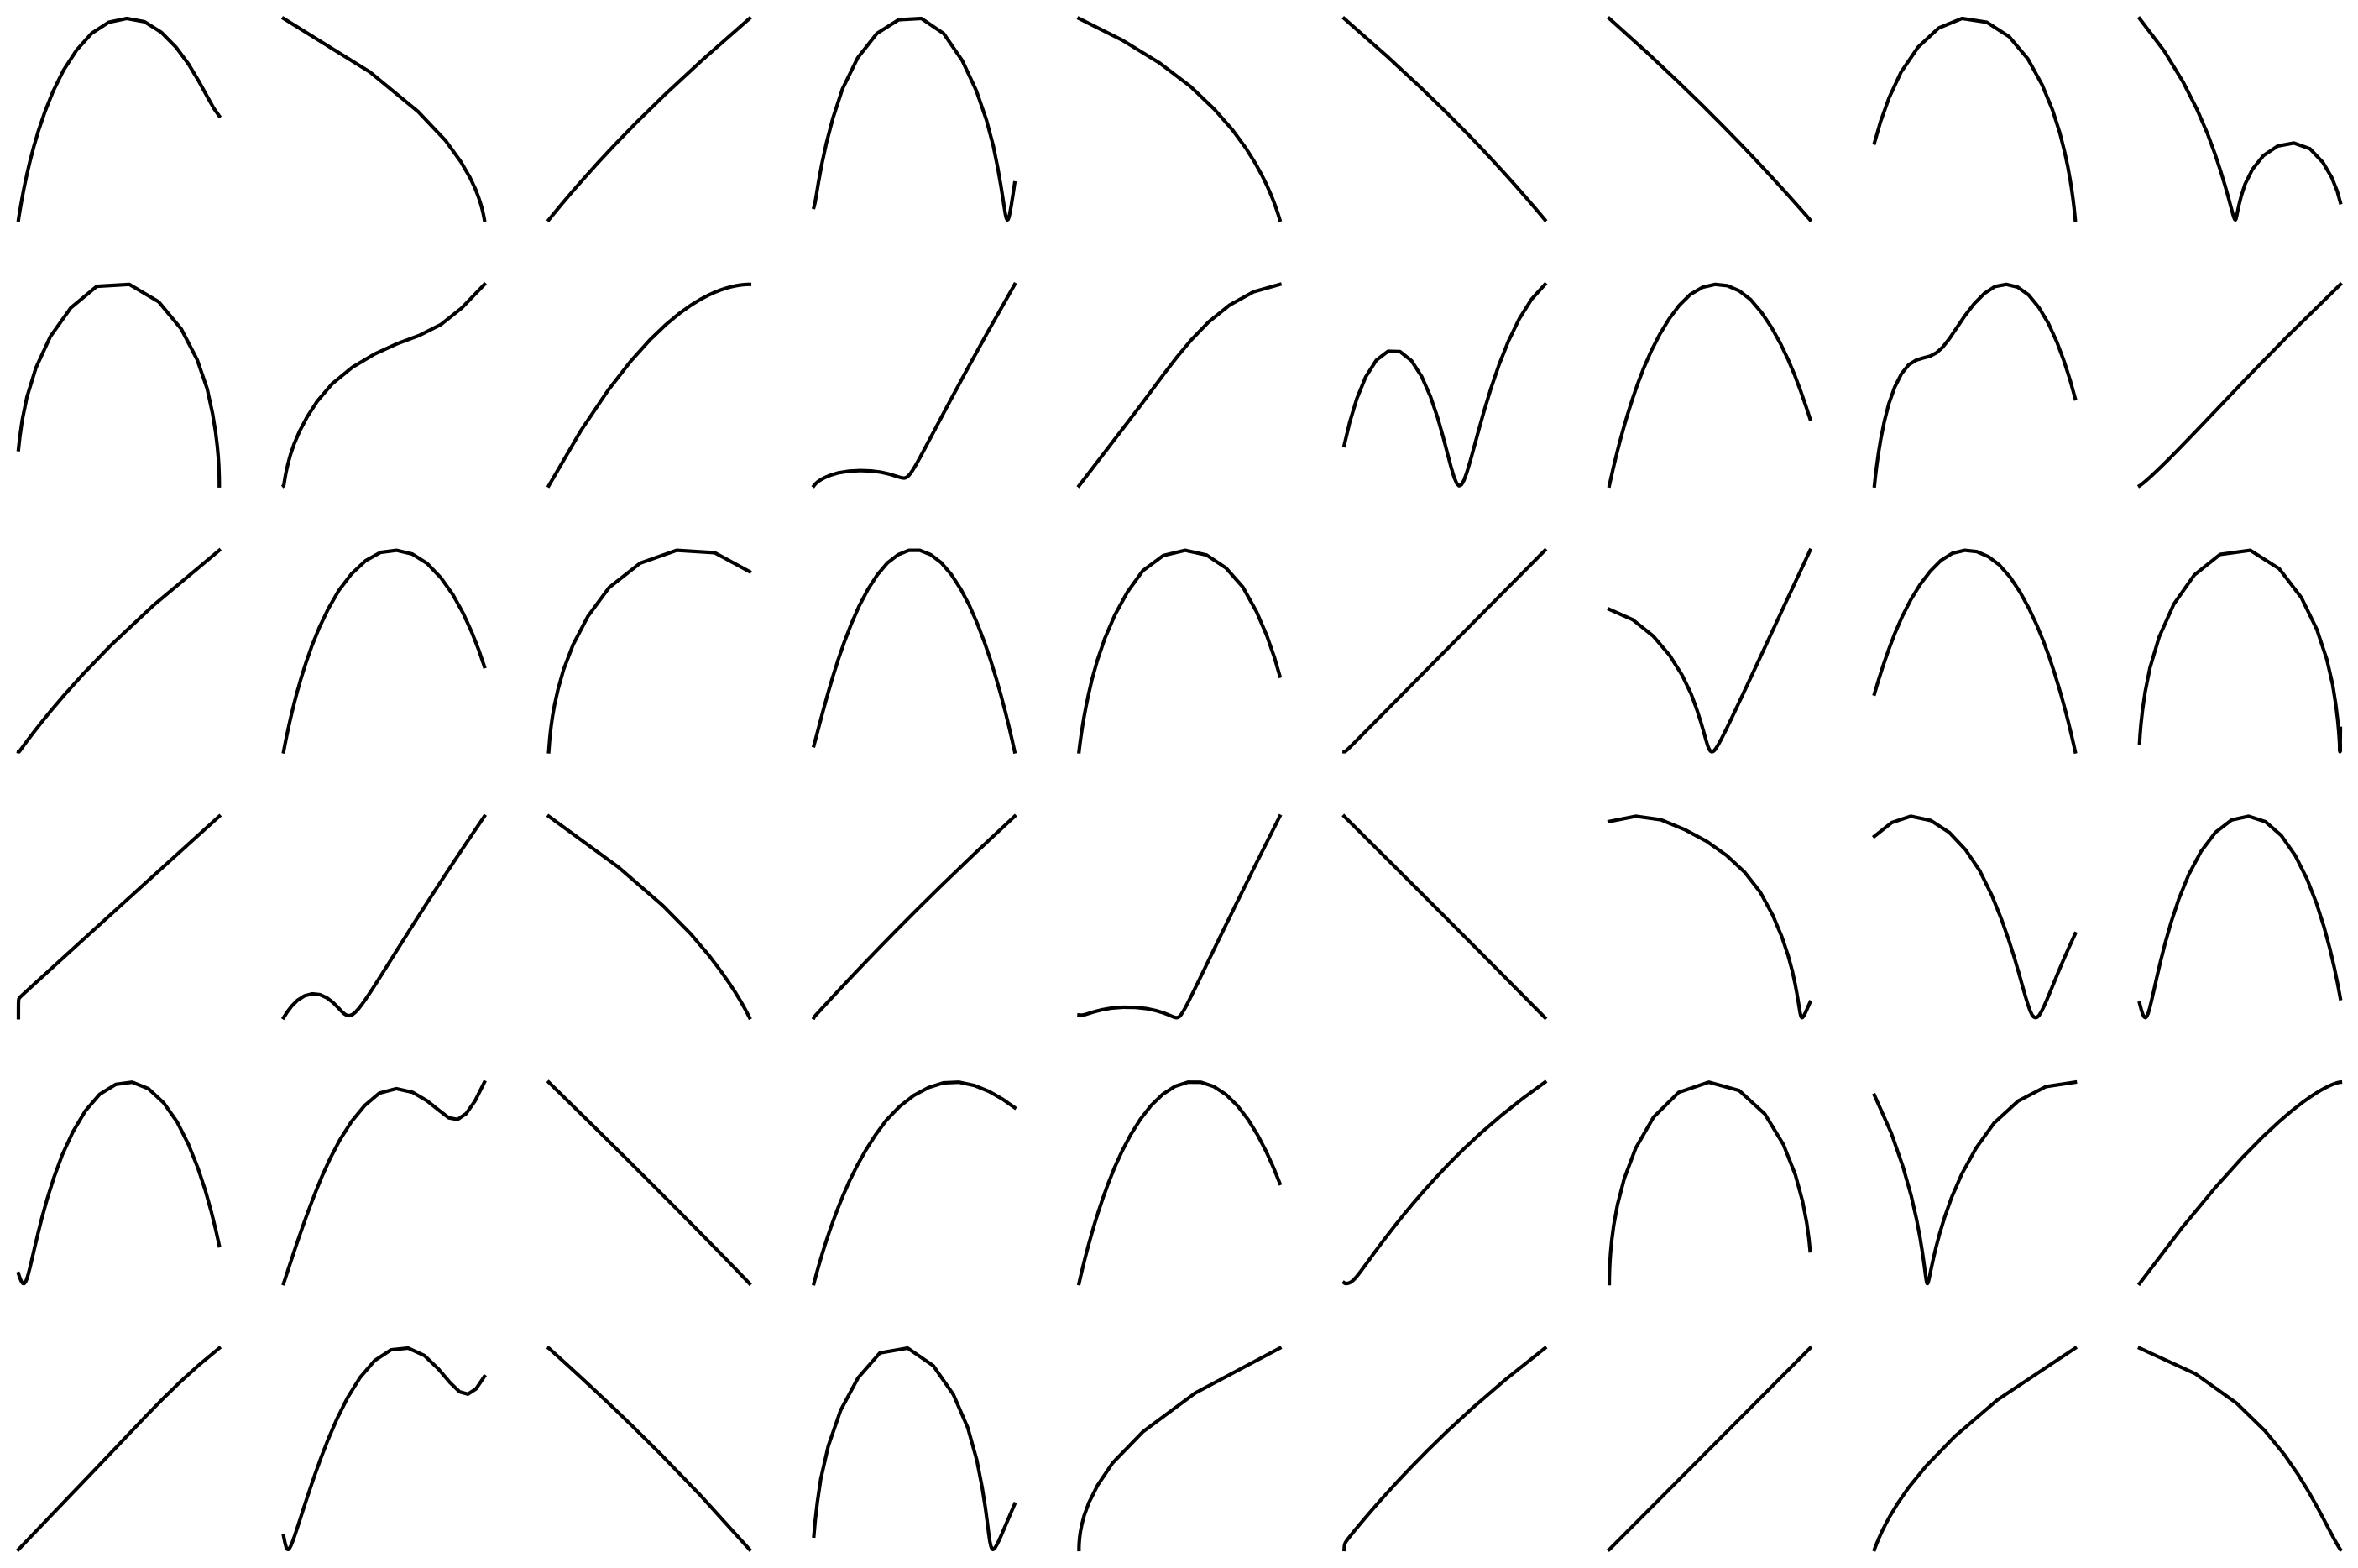

In [7]:
# Visualize data as images (used for the CNN)
rows = 6 
cols = 9 
fig, axs = plt.subplots(rows, cols, sharex=False, sharey=False, figsize=(4*cols, 4*rows), frameon=False)
for i in range(rows):
    if i == 0:
        axs[i, 0].set_ylabel("zreal")
    for j in range(cols):
        axs[i, j].set_axis_off()
        axs[i, j].plot(df['zreal'][i*cols+j], -df['zimag'][i*cols+j], linewidth=3, color='black')

axs[i, j].set_xlabel('Frequency (Hz)')
if save_figs:
    fig.savefig('figures/eis_art.eps')
    fig.savefig('figures/eis_art.pdf')
plt.show()

Text(0.5, 1.0, 'All spectra')

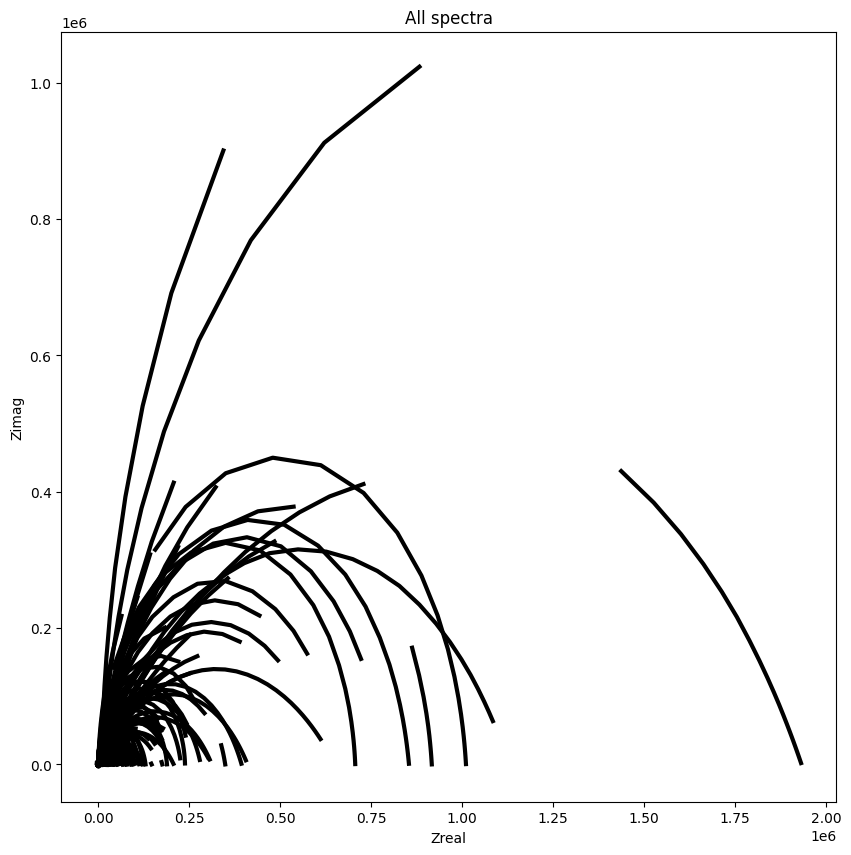

In [8]:
# Showcase outliers by plotting all spectra in a single plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i in range(len(df)):
    ax.plot(df['zreal'][i], -df['zimag'][i], linewidth=3, color='black')
ax.set_xlabel('Zreal')
ax.set_ylabel('Zimag')
ax.set_title('All spectra')

In [16]:
# Correlation coefficeint anlysis between spectra based on the interpolated data
df_sorted


,freq,Z,Circuit,Parameters,f,zreal,zimag
4327,"[10.0, 13.4339933, 18.0472177, 24.2446202, 32....","[(55187.13759362-385.02099173j), (55128.020019...",L-R-RCPE,"L1: 1.10e-08, R1: 4.40e-01, R2: 5.55e+04, CPE1...","[10.0, 13.73823795883263, 18.873918221350976, ...","[55187.13759362, 55123.43464224415, 55047.5838...","[-385.02099173, -456.6978420592999, -541.54754..."
4528,"[1.0, 1.49623566, 2.23872114, 3.34965439, 5.01...","[(5.9999404+3.86579984e-07j), (5.99994038+5.92...",L-R-RCPE,"L1: 4.56e-07, R1: 5.19e+00, R2: 8.13e-01, CPE1...","[10.0, 13.73823795883263, 18.873918221350976, ...","[5.9999402463948535, 5.9999402028651, 5.999940...","[4.255276265202103e-06, 5.891237369011506e-06,..."
4532,"[0.01, 0.0148907532, 0.0221734532, 0.033017942...","[(1096.56438294-0.0160760944j), (1096.56419194...",L-R-RCPE,"L1: 5.58e-06, R1: 2.67e+00, R2: 1.09e+03, CPE1...","[10.0, 13.73823795883263, 18.873918221350976, ...","[1096.0116528280955, 1095.7153482108824, 1095....","[-14.403395175289388, -19.68382649944454, -26...."
798,"[0.01, 0.0126260011, 0.0159415904, 0.020127853...","[(1207.82795-180.572381j), (1187.50311-216.811...",L-R-RCPE,"L1: 1.66e-08, R1: 6.06e-01, R2: 1.27e+03, CPE1...","[10.0, 13.73823795883263, 18.873918221350976, ...","[4.156719209904136, 3.212579183779868, 2.56865...","[-17.86337848459914, -13.372442092237836, -10...."
4542,"[0.01, 0.0134298195, 0.0180360052, 0.024222029...","[(3207.09155223-0.005579137j), (3207.09077526-...",L-R-RCPE,"L1: 1.82e-08, R1: 7.83e+00, R2: 3.20e+03, CPE1...","[10.0, 13.73823795883263, 18.873918221350976, ...","[3206.8343838648025, 3206.7789263655973, 3206....","[-0.3671291394413271, -0.4450732962883444, -0...."
...,...,...,...,...,...,...,...
6220,"[0.01, 0.0148907532, 0.0221734532, 0.033017942...","[(1.97515611-0.0019106j), (1.97505791-0.002765...",Rs_Ws,"R1: 1.97e-01, W1_R: 1.78e+00, W1_T: 2.10e-01, ...","[10.0, 13.73823795883263, 18.873918221350976, ...","[1.396732055165817, 1.2050640500233463, 1.0166...","[-0.638301221266629, -0.6613011530375311, -0.6..."
2756,"[1.0, 1.5019887, 2.25597007, 3.38844156, 5.089...","[(9.73169611-0.07542095j), (9.71498082-0.06615...",Rs_Ws,"R1: 9.60e+00, W1_R: 1.10e+00, W1_T: 4.34e+02, ...","[10.0, 13.73823795883263, 18.873918221350976, ...","[9.660950154090756, 9.654617606397403, 9.64872...","[-0.036211590587099704, -0.03270184740391994, ..."
3761,"[0.01, 0.0126295794, 0.0159506277, 0.020144971...","[(7312.44759149-0.00687987829j), (7312.4480521...",Rs_Ws,"R1: 4.50e+01, W1_R: 7.27e+03, W1_T: 1.36e-03, ...","[10.0, 13.73823795883263, 18.873918221350976, ...","[7316.323424758264, 7317.97628561689, 7320.321...","[-17.875690407667378, -25.64999221101079, -36...."
5598,"[1.0, 1.26485522, 1.59985872, 2.02358965, 2.55...","[(12.78099664-3.83394821j), (12.24256829-3.646...",Rs_Ws,"R1: 1.75e+00, W1_R: 6.77e+01, W1_T: 3.83e+03, ...","[10.0, 13.73823795883263, 18.873918221350976, ...","[8.513978245165196, 8.069882288613986, 7.66201...","[-2.3503382004544853, -2.1959572315909104, -2...."


In [44]:
frequency_range = df_sorted['f'][0]
circuit_class = df_sorted['Circuit']
z_real = df_sorted['zreal']
z_imag = df_sorted['zimag']

# Turn z_real and z_imag into a numpy array
z_real_list = []
z_imag_list = []
for i in range(len(z_real)):
    z_real_list.append(z_real[i])
    z_imag_list.append(z_imag[i])

z_real_array = np.array(z_real_list)
z_imag_array = np.array(z_imag_list)

# Calculate the correlation coefficient between each indivdual spectrum 
corr_real = np.corrcoef(z_real_list)
corr_imag = np.corrcoef(z_imag_list)


invalid value encountered in true_divide
invalid value encountered in true_divide


In [50]:
corr_real = np.corrcoef(z_real_list)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [51]:
corr_imag = np.corrcoef(z_imag_list)

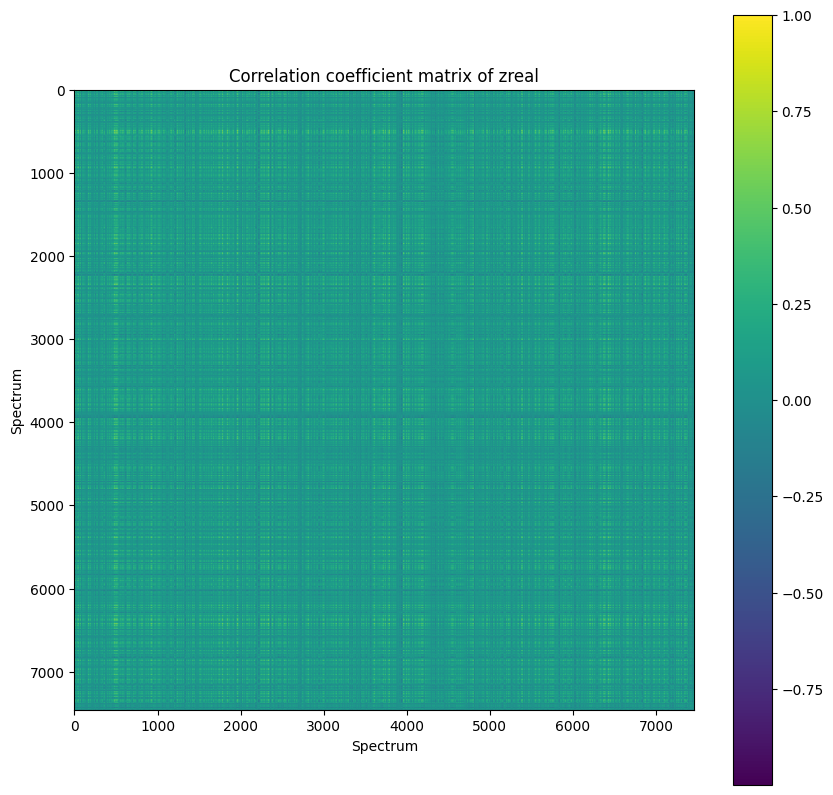

In [53]:
# imshow of the correlation coefficient matrix
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(corr_imag)
ax.set_title('Correlation coefficient matrix of zreal')
ax.set_xlabel('Spectrum')
ax.set_ylabel('Spectrum')
# show the colorbar
fig.colorbar(ax.imshow(corr_imag), ax=ax)


In [38]:
# concatenat two arrays into one
z_r = np.concatenate((z_real[1].reshape((1,-1)), z_real[0].reshape((1,-1))), axis=0)

Text(0.5, 0, 'Spectrum')

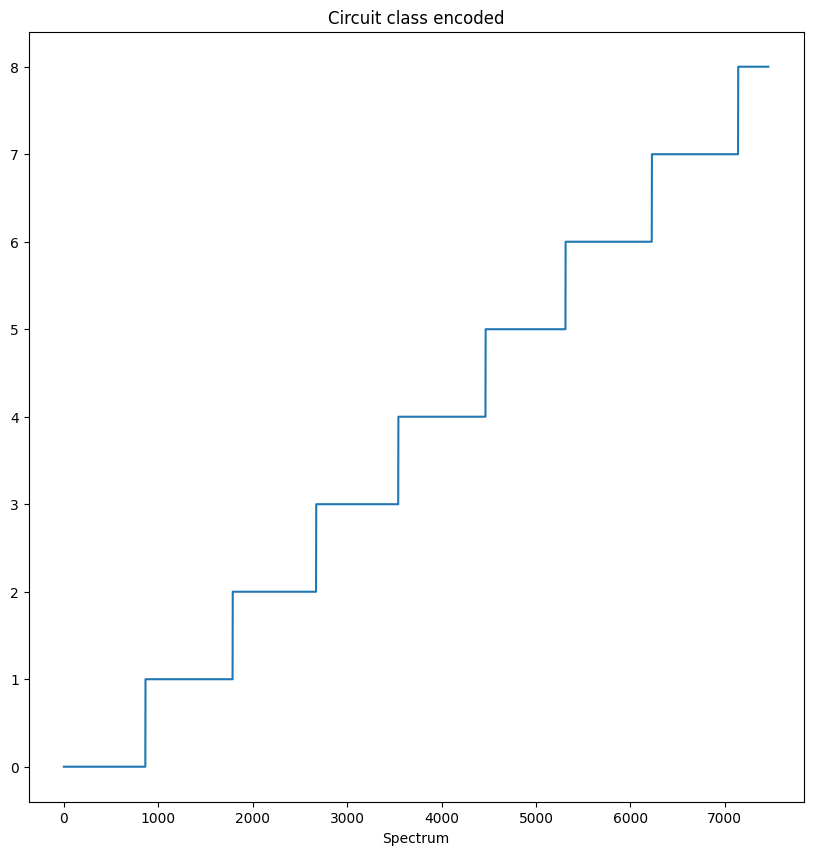

In [55]:
# Get the indices where the circuit class changes
# encode the circuit class as integers
le = LabelEncoder()
le.fit(circuit_class)
circuit_class_encoded = le.transform(circuit_class)

# plot circui class encoded
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(circuit_class_encoded)
ax.set_title('Circuit class encoded')
ax.set_xlabel('Spectrum')


In [ ]:
# 
# Plot the cicruit type below
# correlation of z_reals, z_imags and z_abs

# Cluster and then corraltion coefffs. 

In [ ]:
# Set up a k-means clustering algorithm to cluster the dat ainto 9 classes and then plot the results

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9, random_state=0).fit(z_real_list)